
# Boosting and Stacking


In [ ]:
# Packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore') 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor


## Data


In [ ]:
data=pd.read_csv('train.csv', index_col=[0]) # we'll further divide it into training and testing sets for model evaluation and selection
data.head()

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,85,f,2,t,-37.81554,144.96526,Apartment,Private room,4,0.5,1.0,0.0,300.0,11.0,27,1,25,115,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,3.68
2,151,f,18,f,-37.91984,145.03395,Apartment,Entire home/apt,6,2.0,2.0,3.0,200.0,120.0,10,1,1125,4,95.0,10.0,9.0,10.0,10.0,10.0,10.0,t,moderate,0.82
3,188,f,1,t,-37.64818,145.54512,Guesthouse,Entire home/apt,6,1.0,3.0,4.0,0.0,20.0,0,1,1124,200,93.0,9.0,9.0,10.0,10.0,10.0,9.0,t,strict_14_with_grace_period,5.50
4,200,f,1,t,-37.80245,144.98457,Apartment,Entire home/apt,4,2.5,2.0,2.0,0.0,50.0,0,1,30,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,flexible,0.26
5,90,t,2,f,-37.81796,144.96541,Apartment,Entire home/apt,2,1.0,1.0,1.0,200.0,45.0,0,1,14,129,98.0,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,8.06


In [ ]:
data.shape

(7000, 28)

In [ ]:
leaderboard=pd.read_csv('test.csv', index_col=[0]) # we'll use it for predictions for Kaggle
data.head()

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,85,f,2,t,-37.81554,144.96526,Apartment,Private room,4,0.5,1.0,0.0,300.0,11.0,27,1,25,115,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,3.68
2,151,f,18,f,-37.91984,145.03395,Apartment,Entire home/apt,6,2.0,2.0,3.0,200.0,120.0,10,1,1125,4,95.0,10.0,9.0,10.0,10.0,10.0,10.0,t,moderate,0.82
3,188,f,1,t,-37.64818,145.54512,Guesthouse,Entire home/apt,6,1.0,3.0,4.0,0.0,20.0,0,1,1124,200,93.0,9.0,9.0,10.0,10.0,10.0,9.0,t,strict_14_with_grace_period,5.50
4,200,f,1,t,-37.80245,144.98457,Apartment,Entire home/apt,4,2.5,2.0,2.0,0.0,50.0,0,1,30,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,flexible,0.26
5,90,t,2,f,-37.81796,144.96541,Apartment,Entire home/apt,2,1.0,1.0,1.0,200.0,45.0,0,1,14,129,98.0,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,8.06


In [ ]:
leaderboard.shape

(7000, 27)

In [ ]:
data=data.drop([2160,2452,3820,4046,5919], axis=0) #deleting outliers

In [ ]:
data=data.drop([6047,84,3945,4224,5726,2929], axis=0) #deleting outliers 

In [ ]:
data['price'].nlargest()

id
1963    5000
6028    4445
5041    3645
95      3400
5652    2501
Name: price, dtype: int64

In [ ]:
data['price'].nsmallest()

id
1206    13
689     14
1364    14
1983    14
2569    18
Name: price, dtype: int64

In [ ]:
data.shape

(6989, 28)

In [ ]:
data.describe()

,price,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,6989.000000,6989.000000,6989.000000,6989.000000,6989.000000,6982.000000,6988.000000,6986.00000,5072.000000,5599.000000,6989.000000,6989.000000,6989.000000,6989.000000,5641.000000,5633.000000,5637.000000,5630.000000,5635.000000,5631.000000,5629.000000,5763.000000
mean,152.192588,10.479611,-37.826114,145.009923,3.545858,1.297551,1.563108,2.03049,312.492902,67.685658,13.400343,4.068250,814.036057,24.890113,94.133842,9.642109,9.388682,9.712789,9.745164,9.743918,9.464914,1.641468
std,180.129647,25.427345,0.066293,0.129920,2.217384,0.575248,0.960294,1.52744,489.559789,60.421771,21.546139,28.094743,8785.371742,42.965947,8.354469,0.802881,0.994966,0.726693,0.727771,0.633680,0.865750,1.711439
min,13.000000,0.000000,-38.224430,144.532590,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.020000
25%,75.000000,1.000000,-37.850720,144.957890,2.000000,1.000000,1.000000,1.00000,0.000000,28.000000,0.000000,1.000000,40.000000,1.000000,92.000000,9.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0.330000
50%,119.000000,2.000000,-37.817690,144.977400,3.000000,1.000000,1.000000,2.00000,200.000000,60.000000,0.000000,2.000000,1125.000000,7.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.050000
75%,171.000000,5.000000,-37.803490,145.009340,4.000000,1.500000,2.000000,2.00000,400.000000,90.000000,20.000000,3.000000,1125.000000,29.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.370000
max,5000.000000,294.000000,-37.484830,145.839130,16.000000,9.500000,16.000000,22.00000,6958.000000,668.000000,418.000000,1120.000000,730365.000000,563.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,13.750000


In [ ]:
data['maximum_nights'].nlargest()

id
722     730365
1906     70000
1611     10000
2094     10000
6387     10000
Name: maximum_nights, dtype: int64

In [ ]:
data['maximum_nights'].nlargest()

id
722     730365
1906     70000
1611     10000
2094     10000
6387     10000
Name: maximum_nights, dtype: int64

In [ ]:
data=data.drop(722, axis=0) #722 contains a sort of typo (730365) => deleting it

In [ ]:
data['minimum_nights'].nlargest()

id
996     1120
1920    1000
4343    1000
5786    1000
515      500
Name: minimum_nights, dtype: int64

In [ ]:
data.groupby('property_type')['price'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Aparthotel,3.0,164.33,17.47,145.0,157.00,169.0,174.00,179.0
Apartment,3982.0,144.39,146.57,18.0,90.00,119.0,161.00,5000.0
Bed and breakfast,79.0,155.52,181.83,26.0,72.00,135.0,176.50,1601.0
Boat,2.0,279.00,240.42,109.0,194.00,279.0,364.00,449.0
Boutique hotel,5.0,154.80,85.69,85.0,109.00,119.0,161.00,300.0
Bungalow,40.0,102.22,53.17,28.0,65.00,89.0,129.00,270.0
Cabin,16.0,155.31,68.60,55.0,113.00,151.0,193.25,280.0
Camper/RV,4.0,62.00,27.80,38.0,43.25,55.0,73.75,100.0
Campsite,4.0,26.00,0.00,26.0,26.00,26.0,26.00,26.0


Splitting the data into training (70%) and test sets (30%).

# EDA

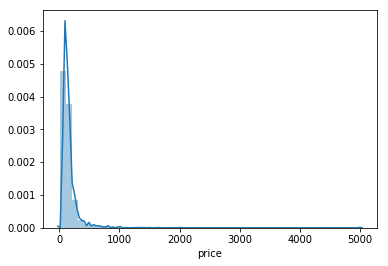

In [ ]:
sns.distplot(data['price'])
plt.show()

In [ ]:
data['log_price'] = np.log(data['price'])

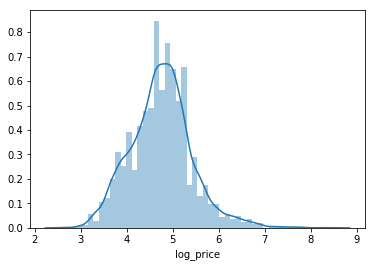

In [ ]:
sns.distplot(data['log_price'])
plt.show()

In [ ]:
# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=5)

# Write training and test sets for model selection. 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

In [ ]:
def prepare_data(df):
    df['host_is_superhost']=(df['host_is_superhost'] =='t').astype(int) 
    
    df['host_identity_verified']=(df['host_identity_verified'] =='t').astype(int)
    
    df['instant_bookable']=(df['instant_bookable'] =='t').astype(int)
    # cancellation_policy
    df['flexible']=(df['cancellation_policy'] =='flexible').astype(int)
    df['moderate']=(df['cancellation_policy'] =='moderate').astype(int)
    df['strict_14_with_grace_period']=(df['cancellation_policy'] =='strict_14_with_grace_period').astype(int)
    # room_type  
    df['Private room']=(df['room_type'] =='Private room').astype(int)
    df['Entire home/apt']=(df['room_type'] =='Entire home/apt').astype(int)
    # property_type
    # Property type. All types with count less than 20 are treated as Other
    df['property_apt']=(df['property_type'] =='Apartment').astype(int)
    df['property_bnb']=(df['property_type'] =='Bed and breakfast').astype(int)
    df['property_bungalow']=(df['property_type'] =='Bungalow').astype(int)
    df['property_condominium']=(df['property_type'] =='Condominium').astype(int)
    df['property_cottage']=(df['property_type'] =='Cottage').astype(int)
    df['property_guest_house']=(df['property_type'] =='Guesthouse').astype(int)
    df['property_guest_suite']=(df['property_type'] =='Guest suite').astype(int)
    df['property_house']=(df['property_type'] =='House').astype(int)
    df['property_loft']=(df['property_type'] =='Loft').astype(int)
    df['property_serviced_apt']=(df['property_type'] =='Serviced apartment').astype(int)
    df['property_townhouse']=(df['property_type'] =='Townhouse').astype(int)
    df['property_villa']=(df['property_type'] =='Villa').astype(int)

    
    df = df.fillna(0) # replace all NaNs with zeros
    df=df.loc[:, df.dtypes!='object'] # discards the columns that are not numerical
    return df
    
train = prepare_data(train)
test = prepare_data(test)
leaderboard = prepare_data(leaderboard)
   
train.head()    

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,log_price,flexible,moderate,strict_14_with_grace_period,Private room,Entire home/apt,property_apt,property_bnb,property_bungalow,property_condominium,property_cottage,property_guest_house,property_guest_suite,property_house,property_loft,property_serviced_apt,property_townhouse,property_villa
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5004,158,0,18,0,-37.82121,144.94186,6,1.0,2.0,3.0,200.0,120.0,10,1,1125,2,100.0,10.0,10.0,10.0,10.0,9.0,9.0,1,1.18,5.062595,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
6327,145,1,1,0,-37.99011,145.32888,6,1.0,3.0,3.0,500.0,0.0,25,2,35,28,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.40,4.976734,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3640,250,0,1,0,-37.76984,145.17642,2,1.0,1.0,1.0,200.0,20.0,30,1,365,4,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0.22,5.521461,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
990,45,1,1,1,-37.89575,144.99950,1,1.0,1.0,1.0,0.0,15.0,0,2,14,47,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.94,3.806662,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4143,90,0,1,1,-38.11442,145.12736,3,1.0,1.0,1.0,0.0,45.0,10,2,1125,74,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1.60,4.499810,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
train.shape

(4891, 43)

In [ ]:
test.shape

(2097, 43)

In [ ]:
leaderboard.shape

(7000, 41)

In [ ]:
train.columns

Index(['price', 'host_is_superhost', 'host_total_listings_count',
       'host_identity_verified', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee',
       'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'log_price', 'flexible', 'moderate', 'strict_14_with_grace_period',
       'Private room', 'Entire home/apt', 'property_apt', 'property_bnb',
       'property_bungalow', 'property_condominium', 'property_cottage',
       'property_guest_house', 'property_guest_suite', 'property_house',
       'property_loft', 'property_serviced_apt', 'property_townhouse',
       'property_villa'],
      dtype='object')

In [ ]:
response='price'
predictors=['host_is_superhost', 'host_total_listings_count',
       'host_identity_verified', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee',
       'extra_people', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'instant_bookable', 'reviews_per_month',
       'flexible', 'moderate', 'strict_14_with_grace_period', 'Private room',
       'Entire home/apt', 'property_apt', 'property_bnb', 'property_bungalow',
       'property_condominium', 'property_cottage', 'property_guest_house',
       'property_guest_suite', 'property_house', 'property_loft',
       'property_serviced_apt', 'property_townhouse', 'property_villa']

train = train[[response]+predictors] # discarding variables that we will not use (in fact here we use all the variables)
test = test[[response]+predictors]
leaderboard = leaderboard[predictors]

In [ ]:
# Write training and test response vectors (log-transformed)
y_train = np.log(train[response])
y_test = np.log(test[response])

# Write training and test design matrices
X_train = train[predictors].copy()
X_test = test[predictors].copy()
X_leaderboard = leaderboard[predictors].copy()

**** Our Y is the logarithm of the 'price'.

## More EDA

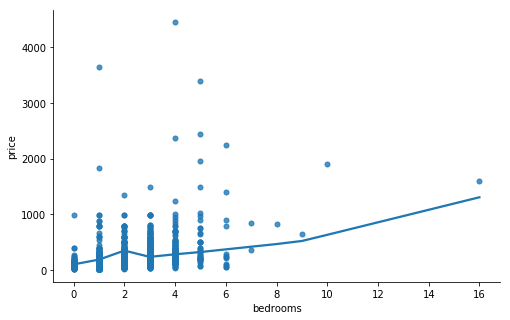

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['bedrooms'], train['price'], scatter_kws={'s': 25}, lowess=True)
sns.despine()
fig.show()

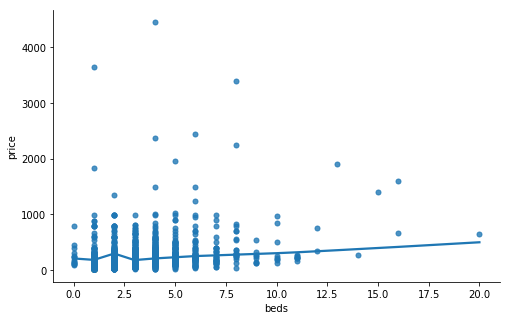

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['beds'], train['price'], scatter_kws={'s': 25}, lowess=True)
sns.despine()
fig.show()

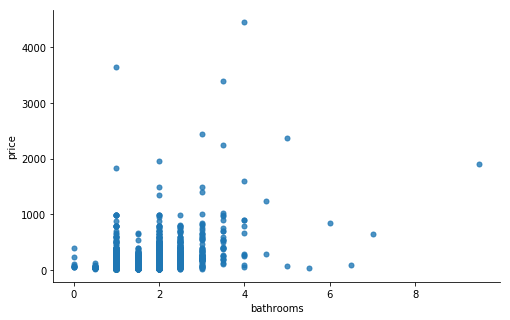

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['bathrooms'], train['price'], scatter_kws={'s': 25}, lowess=True)
sns.despine()
fig.show()

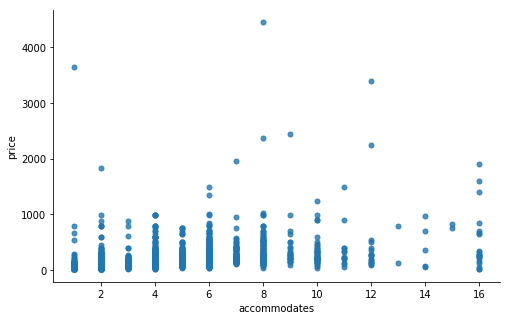

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['accommodates'], train['price'], scatter_kws={'s': 25}, lowess=True)
sns.despine()
fig.show()

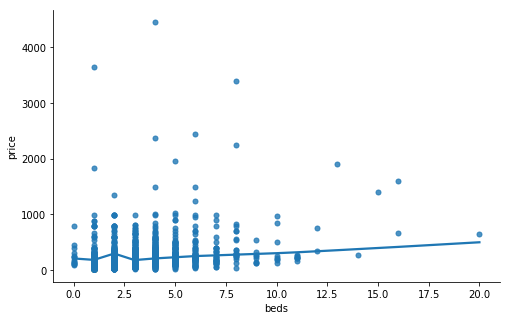

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['beds'], train['price'], scatter_kws={'s': 25}, lowess=True)
sns.despine()
fig.show()

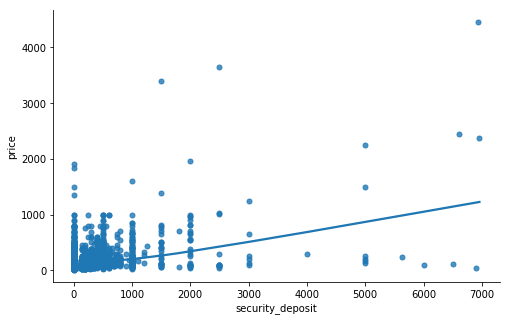

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['security_deposit'], train['price'], scatter_kws={'s': 25}, lowess=True)
sns.despine()
fig.show()

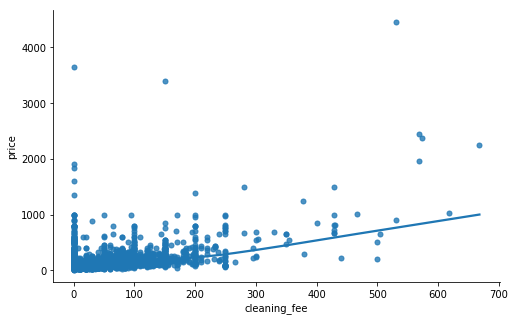

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['cleaning_fee'], train['price'], scatter_kws={'s': 25}, lowess=True)
sns.despine()
fig.show()

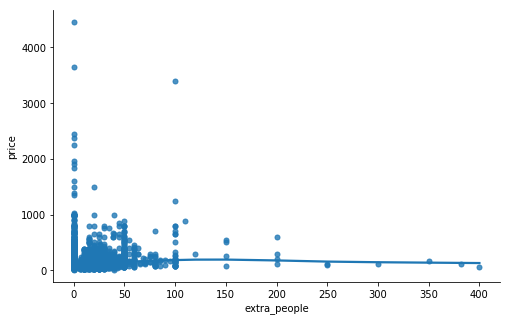

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['extra_people'], train['price'], scatter_kws={'s': 25}, lowess=True)
sns.despine()
fig.show()

## Linear Regression 

In [ ]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Regularised Linear Models


### Lasso

In [ ]:
%%time

lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

CPU times: user 247 ms, sys: 154 ms, total: 401 ms
Wall time: 222 ms


### Ridge Regression

In [ ]:
%%time

alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

CPU times: user 6.43 s, sys: 4.49 s, total: 10.9 s
Wall time: 5.5 s


### Elastic Net

In [ ]:
%%time

enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

CPU times: user 2 s, sys: 1.41 s, total: 3.4 s
Wall time: 1.75 s


## Regression Tree

In [ ]:
%%time

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20,30],
    'max_depth': np.arange(1,30),
}

tree = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False)
tree.fit(X_train, y_train)

print('Best parameters:', tree.best_params_)

Best parameters: {'min_samples_leaf': 20, 'max_depth': 10}
CPU times: user 2.84 s, sys: 9.76 ms, total: 2.85 s
Wall time: 2.85 s


## Bagging


In [ ]:
%%time

bag = BaggingRegressor(n_estimators=500, random_state=1)
bag.fit(X_train, y_train)

CPU times: user 19.5 s, sys: 226 ms, total: 19.7 s
Wall time: 19.8 s


## Random Forest Regression

In [ ]:
%%time

model = RandomForestRegressor(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 11} 

CPU times: user 2.1 s, sys: 148 ms, total: 2.25 s
Wall time: 55.8 s


In [ ]:
model = RandomForestRegressor(criterion='mse',  n_estimators=1000, random_state=1)

tuning_parameters = {
    'min_samples_leaf': [1, 3, 5, 7, 10, 15, 20, 25, 35, 40, 45, 50],
    'max_features': np.arange(1, len(predictors)+1),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv=5, n_iter=16, return_train_score=False, n_jobs=4)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 11} 



In [ ]:
rf.n_estimators = 1500
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=11, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

## Boosting

Boosting has three crucial tuning parameters:

<li style="margin-top:15px; margin-bottom: 10px"> The learning rate.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The number of trees.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The size of each tree.</li> 

In addition, we may want to use stochastic gradient boosting by fitting each tree based on a subsample of the training data. 
 

###SKLearn Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, n_estimators= 750, subsample = 1.0)
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=750,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Randomised search to tune the model. 

In [ ]:
%%time

model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2 ,3, 4,5,6,7,8,9,10],
    'subsample' : [0.6, 0.8, 1.0]
}

# Using GridSearchCV would be too slow. Increase the number of iterations to explore more hyperparameter combinations.
gb = RandomizedSearchCV(model, tuning_parameters, n_iter = 20, cv = 10, return_train_score=False, n_jobs=4)
gb.fit(X_train, y_train)

print('Best parameters found by randomised search:', gb.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.01} 

CPU times: user 25.3 s, sys: 172 ms, total: 25.4 s
Wall time: 31min 23s


In [ ]:
gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Variable importance

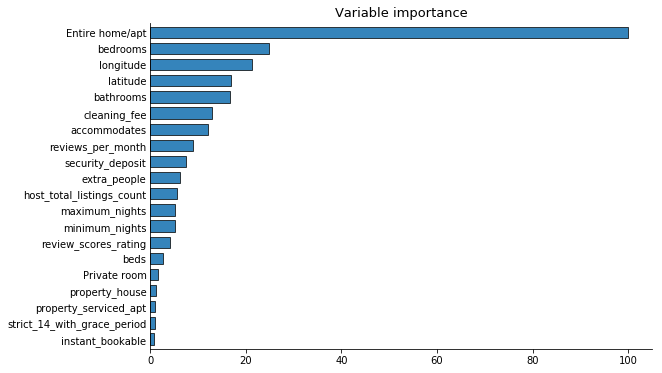

In [ ]:
from statlearning import plot_feature_importance

plot_feature_importance(gb.best_estimator_, predictors)
plt.show()

### XGBoost


In [ ]:
from matplotlib import pyplot

In [ ]:
%%time

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4, 4, 5, 6, 7, 8],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, y_train)

xbst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')



[08:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found by randomised search: {'subsample': 0.6, 'n_estimators': 1500, 'max_depth': 6, 'learning_rate': 0.01} 

CPU times: user 18.6 s, sys: 93.2 ms, total: 18.7 s
Wall time: 8min 13s


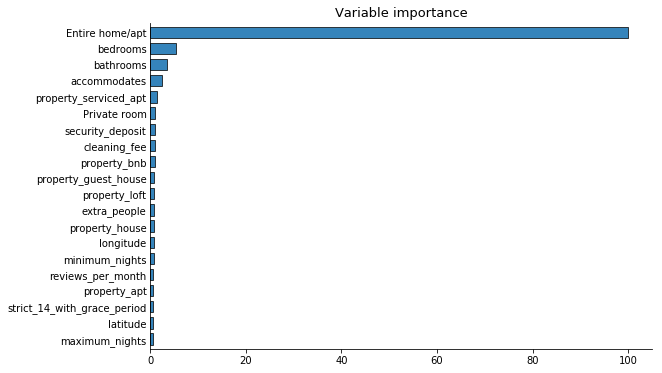

In [ ]:
plot_feature_importance(xbst, labels=predictors)
plt.show()

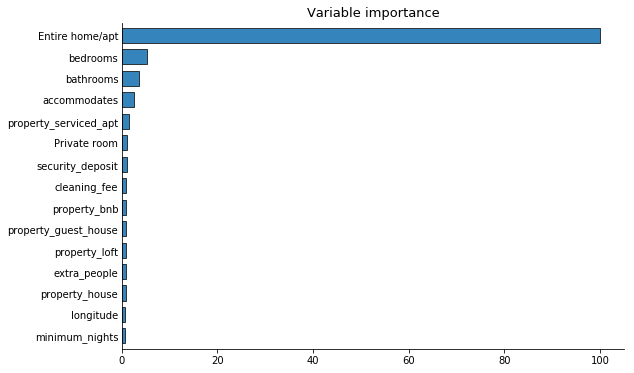

In [ ]:
plot_feature_importance(xbst, labels=predictors, max_features=15)
plt.show()

Selecting the number of boosting iterations by cross-validation and early stopping. 

In [ ]:
%%time

dtrain = xgb.DMatrix(X_train, y_train) # we need to convert the data to the format required by xgboost
dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 6, 
    'learning_rate': 0.01, 
    'subsample': 0.6,
    'silent' : 0, 
    'objective':'reg:linear',  
     }

cv = xgb.cv(param, dtrain, num_boost_round = 1500, nfold=10, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,0]:.4f}')

[08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

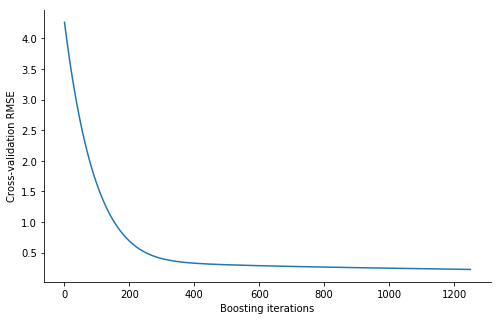

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

### LightGBM


In [ ]:
%%time

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(
    model, tuning_parameters, n_iter=64, cv=5, 
    return_train_score=False, n_jobs=4, random_state=20
)

gb_search.fit(X_train, y_train)

lbst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.6, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.05} 

CPU times: user 3.15 s, sys: 472 ms, total: 3.62 s
Wall time: 3min 29s


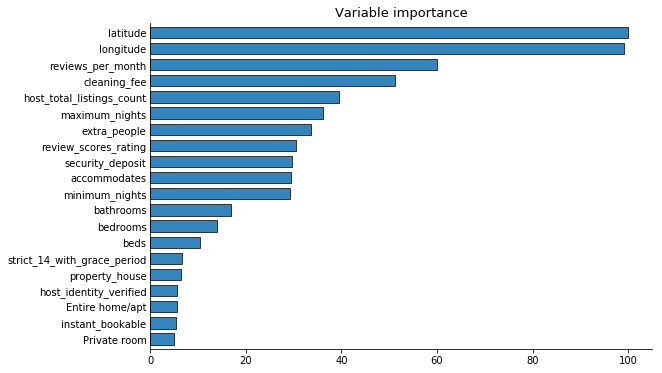

In [ ]:
plot_feature_importance(lbst, labels=predictors)
plt.show()

### Additive Boosting


In [ ]:
%%time

y_fit = lasso.predict(X_train)
resid = y_train - y_fit

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4, 
                               random_state = 20)

gb_search.fit(X_train, resid)

abst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.01} 

CPU times: user 2.4 s, sys: 241 ms, total: 2.64 s
Wall time: 49.8 s


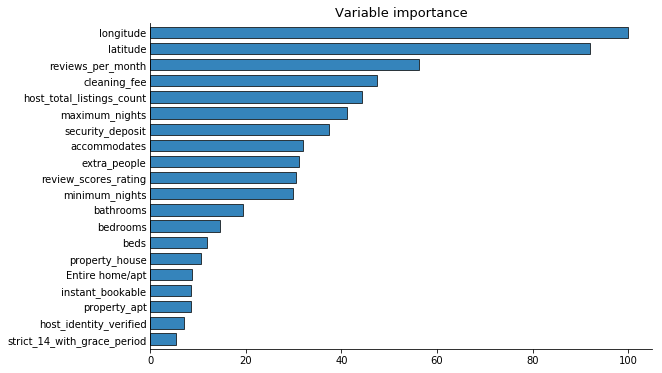

In [ ]:
plot_feature_importance(abst, labels=predictors)
plt.show()

## Model Stacking

In [ ]:
%%time

models = [ols, lasso, ridge, xbst]

stack = StackingCVRegressor(models, meta_regressor=LinearRegression(), cv=10)
stack.fit(X_train.values, y_train.ravel())

[08:50:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## Model Evaluation



####Log prices

In [ ]:
columns=['Test RMSE', 'Test R2']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net', 'Tree', 'Bagged Trees', 'Random Forest', 'SKLearn Boost', 'XGBoost', 'LightGBM', 'Additive Boost', 'Stack']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lasso, ridge, enet, tree, bag, rf, gb, xbst, lbst, abst, stack]

for i, method in enumerate(methods):
    
    if method != stack:
        y_pred= method.predict(X_test)   
        if method == abst:
            y_pred=ols.predict(X_test)+method.predict(X_test)              
    else:
        y_pred= method.predict(X_test.values)
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2
OLS,0.436,0.607
Lasso,0.436,0.607
Ridge,0.436,0.607
Elastic Net,0.436,0.607
Tree,0.442,0.596
Bagged Trees,0.396,0.676
Random Forest,0.391,0.684
SKLearn Boost,0.382,0.698
XGBoost,0.383,0.697
LightGBM,0.386,0.692


Stacking shows the best result here, thus making predictions based on it

Making predictions in the original prices, exponentiating the y values.

In [ ]:
# predicting XGBoost
y_pred = np.exp(xbst.predict(X_leaderboard)) 

leaderboard['Predicted'] = (y_pred) 

In [ ]:
leaderboard['Predicted'].head()

id
1    119.828979
2    177.170166
3    120.997475
4    120.863289
5    270.432831
Name: Predicted, dtype: float32

Making a submission

In [ ]:
submission = pd.DataFrame(np.c_[leaderboard.index, y_pred], columns=['Id', 'Predicted'])
submission['Id'] = submission['Id'].astype(int)
submission.to_csv('kaggle_submission_17_xbst.csv',  index=False)